In [64]:
!pip install -U datasets emoji sentencepiece

In [120]:
from datasets import load_dataset
import re
import html
import emoji
import sentencepiece as spm
from torch.utils.data import Dataset, DataLoader

data = load_dataset("cfilt/iitb-english-hindi")
text = data['train']['translation'][:80000]
vocab_size = 8000

en = [i['en'] for i in text]
hi = [i['hi'] for i in text]

def preprocess(sentence):
    sentence = ' '.join(sentence.split())
    sentence = html.unescape(sentence)
    sentence = re.sub(r'<[^>]+>', '', sentence)
    sentence = sentence.lower()
    sentence = emoji.replace_emoji(sentence, replace='')
    return sentence

en = [preprocess(sent) for sent in en]
hi = [preprocess(sent) for sent in hi]

def list_to_txt(filename, list):
    with open(filename, 'w') as f:
        for i in list:
            f.write(i + '\n')

list_to_txt("hindi_file.txt", hi)
list_to_txt("english_file.txt", en)

spm.SentencePieceTrainer.train(
    input='english_file.txt',
    model_prefix='english',
    vocab_size=vocab_size,
    model_type='bpe',
    character_coverage=0.995,
    pad_id=0,
    unk_id=1,
    bos_id=2,
    eos_id=3,
    normalization_rule_name='nmt_nfkc_cf'
)

spm.SentencePieceTrainer.train(
    input='hindi_file.txt',
    model_prefix='hindi',
    vocab_size=vocab_size,
    model_type='bpe',
    character_coverage=0.999,
    pad_id=0,
    unk_id=1,
    bos_id=2,
    eos_id=3,
    normalization_rule_name='nmt_nfkc_cf'
)

en_sp = spm.SentencePieceProcessor(model_file="english.model")
hi_sp = spm.SentencePieceProcessor(model_file="hindi.model")

class DatasetPreparation(Dataset):
  def __init__(self, model_eng, model_hin, data) -> None:
      super().__init__()
      self.bpe_eng = spm.SentencePieceProcessor(model_file=model_eng)
      self.bpe_hin = spm.SentencePieceProcessor(model_file=model_hin)
      self.data = data

  def __len__(self):
      return len(self.data)

  def __getitem__(self, index):
      eng_sentence = self.data[index]['en']
      hin_sentence = self.data[index]['hi']

      enc_eng = self.bpe_eng.encode(eng_sentence, out_type=int)
      enc_hi = self.bpe_hin.encode(hin_sentence, out_type=int)
    #   enc_hi = [self.bpe_hin.bos_id()] + enc_hi + [self.bpe_hin.eos_id()]
      decoder_inputs = [self.bpe_hin.bos_id()] + enc_hi
      decoder_outputs = enc_hi + [self.bpe_hin.eos_id()]

      return {
          'input_ids': enc_eng,
          'decoder_inputs': decoder_inputs,
          'target_ids': decoder_outputs
      }

train_dataset = DatasetPreparation(model_eng="english.model", model_hin="hindi.model", data=text)
test_dataset = DatasetPreparation(model_eng="english.model", model_hin="hindi.model", data=data['test']['translation'])

import torch

def collate_fn(batch):
    input_ids = [item['input_ids'] for item in batch]
    decoder_inputs = [item['decoder_inputs'] for item in batch]
    target_ids = [item['target_ids'] for item in batch]

    input_lengths = [len(x) for x in input_ids]
    target_lengths = [len(x) for x in target_ids]

    input_padded = torch.nn.utils.rnn.pad_sequence(
        [torch.tensor(x) for x in input_ids], batch_first=True, padding_value=0
    )

    decoder_input_padded = torch.nn.utils.rnn.pad_sequence(
        [torch.tensor(x) for x in decoder_inputs], batch_first=True, padding_value=0
    )

    output_padded = torch.nn.utils.rnn.pad_sequence(
        [torch.tensor(x) for x in target_ids], batch_first=True, padding_value=0
    )

    return {
        'input_ids': input_padded,
        'decoder_inputs': decoder_input_padded,
        'target_ids': output_padded,
        'input_lengths': torch.Tensor(input_lengths),
        'target_lengths': torch.Tensor(target_lengths)
    }

train_loader = DataLoader(
    dataset=train_dataset,
    batch_size=64,
    shuffle=True,
    collate_fn=collate_fn
)

test_loader = DataLoader(
    dataset=test_dataset,
    batch_size=64,
    shuffle=True,
    collate_fn=collate_fn
)

In [121]:
import torch
from torch import nn
import pandas as pd

class Encoder(nn.Module):
    def __init__(self, vocab_size, embd_dropout, input_size, hidden_size, num_layers, dropout):
        super().__init__()
        self.embedding = nn.Embedding(num_embeddings=vocab_size, embedding_dim=input_size, padding_idx=0, max_norm=1)
        self.lstm_layers = nn.LSTM(input_size=input_size, hidden_size=hidden_size, num_layers=num_layers, batch_first=True, dropout=dropout if num_layers>1 else 0, bidirectional=True)
        self.embd_dropout = nn.Dropout(embd_dropout)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        embeddings = self.embedding(x)
        embeddings = self.embd_dropout(embeddings)
        output, (h_n, c_n) = self.lstm_layers(embeddings)
        return output, h_n, c_n

class Decoder(nn.Module):
    def __init__(self, vocab_size, input_size, hidden_size, num_layers, dropout):
        super().__init__()
        self.embedding = nn.Embedding(num_embeddings=vocab_size, embedding_dim=input_size, padding_idx=0, max_norm=1)
        self.lstm_layers = nn.LSTM(input_size=input_size, hidden_size=hidden_size, num_layers=num_layers, batch_first=True, dropout=dropout if num_layers > 1 else 0, bidirectional=False)
        self.out = nn.Linear(in_features=hidden_size, out_features=vocab_size)

    def forward(self, tgt, hidden):
        x = self.embedding(tgt)

        output, (h, c) = self.lstm_layers(x, hidden)
        output = self.out(output)
        return output, h, c

class EncoderDecoderAttention(nn.Module):
    def __init__(self, vocab_size, embd_dropout, input_size, hidden_size, num_layers, dropout):
        super().__init__()
        self.encoder = Encoder(vocab_size=vocab_size, embd_dropout=embd_dropout, input_size=input_size, hidden_size=hidden_size, num_layers=num_layers, dropout=dropout)
        self.linear = nn.ModuleList([
            nn.Linear(in_features=hidden_size*2, out_features=hidden_size) for i in range(num_layers)
        ])

        self.decoder = Decoder(vocab_size=vocab_size, input_size=input_size, hidden_size=hidden_size, num_layers=num_layers, dropout=dropout)

    def combine_bidirectional_outputs(self, matrix, linear):
        m_new = []

        for i in range(len(matrix)//2):
            m_first = matrix[2*i]
            m_second = matrix[2*i+1]
            m_n_new = torch.cat([m_first, m_second], dim=-1)
            m_n_new = torch.tanh(linear[i](m_n_new))
            m_new.append(m_n_new)
        m_new = torch.stack(m_new)

        return m_new

    # Assuing teacher forcing in trainig, forward is coded for teacher forcing training
    # x shape -> (batch, seq_length)
    def forward(self, x: torch.Tensor, tgt: torch.Tensor) -> torch.Tensor:
        """
        x: (batch, seq_len)
        tgt: (batch, seq_len, input_size)
        """
        output, h_n, c_n = self.encoder(x)

        # shapes
        # output: (batch, seq_len, D*hidden_size)
        # h_n, c_n: (D*num_layers, batch, hidden_size) -> changed to (num_layers, batch, hidden_size)

        h_new = self.combine_bidirectional_outputs(matrix=h_n, linear=self.linear)
        c_new = self.combine_bidirectional_outputs(matrix=c_n, linear=self.linear)

        output, h, c = self.decoder(tgt, (h_new, c_new))
        return output

    def inference(self, x:torch.Tensor, max_length=50, start_token=2, end_token=3) -> torch.Tensor:
        """
        x: (batch, input_size), 1 because 1 word of the sequence at a time
        """
        encoder_output, h_n, c_n = self.encoder(x)

        h_new = self.combine_bidirectional_outputs(matrix=h_n, linear=self.linear)
        c_new = self.combine_bidirectional_outputs(matrix=c_n, linear=self.linear)

        # current_vector = torch.unsqueeze(x, 1) # convert x to (batch, 1, input_size)
        batch_size = x.shape[0]
        current_vector = torch.full(size=(batch_size, 1), fill_value=start_token, device=device)
        generations = []

        for _ in range(max_length):
            output_vector, h_new, c_new = self.decoder(current_vector, (h_new, c_new))
            current_vector = output_vector.argmax(dim=-1)
            generations.append(current_vector)
            if (current_vector == end_token).all():
              break

        return torch.cat(generations, dim=1)

device = "cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu"
model = EncoderDecoderAttention(vocab_size=vocab_size, embd_dropout=0.3, input_size=512, hidden_size=512, num_layers=2, dropout=0.3)
model.to(device=device)

model, sum(torch.numel(i) for i in model.parameters() if i.requires_grad), sum(torch.numel(i) for i in model.parameters()), next(model.parameters()).device

(EncoderDecoderAttention(
   (encoder): Encoder(
     (embedding): Embedding(8000, 512, padding_idx=0, max_norm=1)
     (lstm_layers): LSTM(512, 512, num_layers=2, batch_first=True, dropout=0.3, bidirectional=True)
     (embd_dropout): Dropout(p=0.3, inplace=False)
   )
   (linear): ModuleList(
     (0-1): 2 x Linear(in_features=1024, out_features=512, bias=True)
   )
   (decoder): Decoder(
     (embedding): Embedding(8000, 512, padding_idx=0, max_norm=1)
     (lstm_layers): LSTM(512, 512, num_layers=2, batch_first=True, dropout=0.3)
     (out): Linear(in_features=512, out_features=8000, bias=True)
   )
 ),
 28050240,
 28050240,
 device(type='cuda', index=0))

In [122]:
loss_fn = nn.CrossEntropyLoss(ignore_index=0)
optimizer = torch.optim.AdamW(params=model.parameters(), lr=1e-3, weight_decay=1e-5)
scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer=optimizer, T_0=8, eta_min=3e-4)

loss_fn, optimizer, scheduler

(CrossEntropyLoss(),
 AdamW (
 Parameter Group 0
     amsgrad: False
     betas: (0.9, 0.999)
     capturable: False
     differentiable: False
     eps: 1e-08
     foreach: None
     fused: None
     initial_lr: 0.001
     lr: 0.001
     maximize: False
     weight_decay: 1e-05
 ),
 <torch.optim.lr_scheduler.CosineAnnealingWarmRestarts at 0x7e4c50019050>)

In [123]:
len(train_loader)

1250

In [124]:
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction

epochs = 20
epoch_train_loss = []
epoch_train_acc = []

epoch_test_loss = []
epoch_test_acc = []

bleus = []

def calculate_bleu(preds, target, tokenizer):
  score = 0
  for line in range(len(preds)):
    pred_sentence = tokenizer.decode(torch.tensor([i for i in preds[line] if i>3]).tolist())
    tgt_sentence = tokenizer.decode(torch.tensor([i for i in target[line] if i>3]).tolist())
    score += sentence_bleu(pred_sentence.split(), tgt_sentence.split(), smoothing_function=SmoothingFunction().method4)
  return score/len(preds)

def calculate_accuracy(preds, targets):
  masks = targets != 0
  corrects = (preds == targets) & masks
  return corrects.sum().item() / masks.sum().item()

for epoch in range(epochs):
    model.train()
    train_loss, train_acc = 0, 0
    for batch, X in enumerate(train_loader):
        x = X['input_ids'].to(device=device)

        decoder_inputs = X['decoder_inputs'].to(device=device)
        decoder_outputs = X['target_ids'].to(device=device)

        optimizer.zero_grad()
        outputs = model(x, decoder_inputs)
        loss = loss_fn(outputs.view(-1, vocab_size), decoder_outputs.view(-1))

        loss.backward()
        torch.nn.utils.clip_grad_norm(parameters=model.parameters(), max_norm=1.0)
        optimizer.step()

        acc = calculate_accuracy(outputs.argmax(-1), decoder_outputs)

        train_loss += loss.item()
        train_acc += acc

        if batch%200==0:
          print(f"{batch}: {train_loss} {train_acc}")

    epoch_train_loss.append(train_loss/len(train_loader))
    epoch_train_acc.append(train_acc/len(train_loader))

    test_loss, test_acc = 0, 0
    model.eval()
    with torch.no_grad():
        for X in test_loader:
            x = X['input_ids'].to(device=device)
            decoder_inputs = X['decoder_inputs'].to(device=device)
            decoder_targets = X['target_ids'].to(device=device)

            preds = model(x=x, tgt=decoder_inputs)
            loss = loss_fn(preds.view(-1, vocab_size), decoder_targets.view(-1))
            acc = calculate_accuracy(preds.argmax(-1), decoder_targets)

            test_loss += loss.item()
            test_acc += acc

        epoch_test_loss.append(test_loss/len(test_loader))
        epoch_test_acc.append(test_acc/len(test_loader))
    scheduler.step()

    # Calculating blue score of predictions after each epoch
    with torch.no_grad():
      bleu = 0
      for X in test_loader:
        x = X['input_ids'].to(device=device)
        preds = model.inference(x=x)
        bleu_score = calculate_bleu(preds, X['target_ids'], tokenizer=hi_sp)
        bleu += bleu_score
      bleu /= len(test_loader)
    bleus.append(bleu)

    print(f"Epoch: {epoch}, train loss: {epoch_train_loss[-1]}, train acc: {epoch_train_acc[-1]}, test loss: {epoch_test_loss[-1]}, test acc: {epoch_test_acc[-1]}")
    print(f"Bleu: {bleu}")

<ipython-input-124-33dcabb206d6>:39: FutureWarning: `torch.nn.utils.clip_grad_norm` is now deprecated in favor of `torch.nn.utils.clip_grad_norm_`.
  torch.nn.utils.clip_grad_norm(parameters=model.parameters(), max_norm=1.0)


0: 8.99112606048584 0.0
200: 1233.3314700126648 30.775267395031047
400: 2296.728467941284 70.85655749086122
600: 3250.347128868103 121.85462988009144
800: 4127.976053714752 180.32000272678346
1000: 4932.268246650696 246.22268960055953
1200: 5685.316935300827 317.54265072917065
Epoch: 0, train loss: 4.690918356323242, train acc: 0.2684170954187079, test loss: 8.178641748428344, test acc: 0.04904198472991775
Bleu: 0.00017608951259162476
0: 3.1448638439178467 0.45363408521303256
200: 689.8449373245239 79.12251343275351
400: 1350.0421168804169 162.1013659540379
600: 1976.574205160141 249.61022231985626
800: 2570.3735568523407 342.10778630773353
1000: 3140.2229902744293 438.67615351013114
1200: 3691.0627748966217 538.1861591601763
Epoch: 1, train loss: 3.060511735916138, train acc: 0.4502677134926383, test loss: 8.68565092086792, test acc: 0.04891875071857506
Bleu: 1.0222455926016836e-05
0: 2.5922858715057373 0.5265486725663717
200: 508.2549068927765 107.3785717624596
400: 995.329747915268 

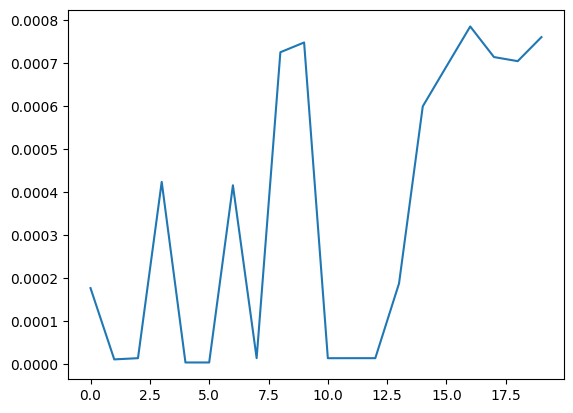

In [125]:
import matplotlib.pyplot as plt

plt.plot(bleus)

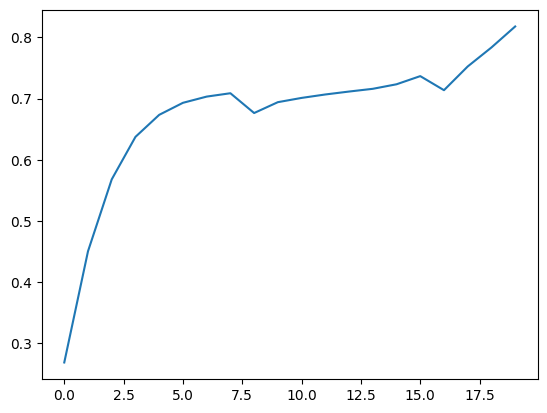

In [126]:
plt.plot(epoch_train_acc)

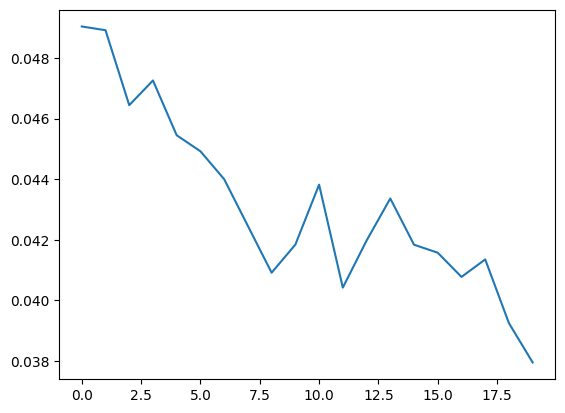

In [127]:
plt.plot(epoch_test_acc)


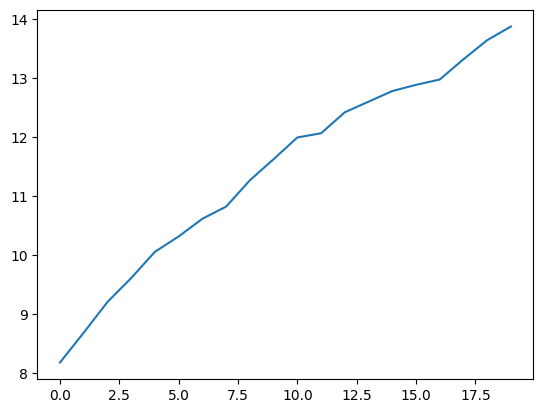

In [128]:
plt.plot(epoch_test_loss)

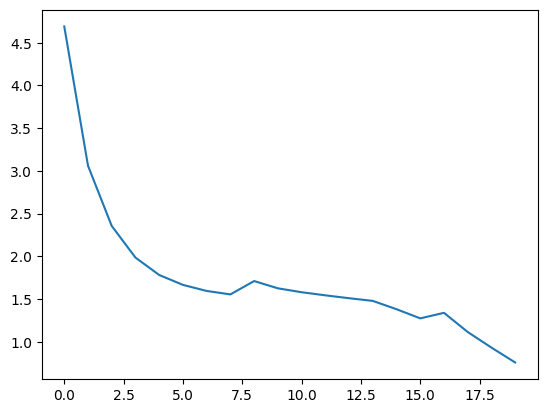

In [129]:
plt.plot(epoch_train_loss)

In [130]:
model.eval()
with torch.no_grad():
  for X in test_loader:
    x = X['input_ids'].to(device=device)
    actuals = X['target_ids']
    preds = model.inference(x=x)
    break

In [131]:
[hi_sp.decode(i.tolist()) for i in preds[:5]]

['clutter बैकएंड आरंभ करने में विफल. के साथ संपर्क के साथ हस्ताक्षर होने की फ़ंद्क लेाक संदेशक भरें/कालीस्रेंस", "कृप्ति", "म- ⁇ ", "string", "string",',
 'यह डिजिटल रूप से गुप्त संदेश का हिस्सा है आप इस रूप से डाउनलोड और फिर डाउनलोड करते हैं. अधिक आप एक से अधिक स्वचालित रूप से बनाई गई हैं अपने आप बाद से अधिक या और नहीं रहेंगे. नहीं, या दाखिल करें',
 'एक नया प्रोजेक्ट बनाएं जोड़ें ऊपर प्रयोक्ता प्रबंधक है नहीं अधिष्ठापित करें. पर सेट करें. संभव है कि कोई आपकी गोपनीय जानकारी, व दोनों की संस्करण. 245 टनेलिंग का प्रयोग करें. का उपयोग करेगा यदि में प्रयोग का',
 'यह डिजिटल रूप से गुप्त संदेश का हिस्सा है आप इस रूप से डाउनलोड और फिर डाउनलोड और और बिना और और फोन पर जुड़े हुए नहीं प्रकाशित चाहते हैं. "me." और नया कनेक्शन को हटाकर चैट रूम से जुड़ने के लिए',
 'gl पिक्सेल उद्धरण अक्षम करें को दिखाएँ. मान के लिए 0 पर सेट करें. पर मान यह अधिक पृष्ठ के लिए 2 2-पर्षित पर अक्षम करें./बैसिका का प्रयोग आपके "त्र नहीं पैदाने']

In [137]:
hi_sp.decode(preds[5].tolist())

'mkisofs का संस्करण समर्थित नहीं है anjuta को? को?ने पर चुनेंः को फिर से डाउनलोड करें संभव है. संदेशः या निर्देशिका सक्षम करें. का प्रयोग करें यदि आप इस नाम को iso9660 मानक के'

In [136]:
hi_sp.decode(actuals[5].tolist())

'इस सप्ताह रेटिंग एजेन्सी, स्टैन्डर्ड्स एंज पुअर्स ने मुख्यतः बढ़ते हुए बंधक (मोर्टगेज) के कारण बढ़ते हुए घरेलू लाभ को, एशियाई बैंकों की  ⁇ णपात्रता के लिए जोखिम कारक बताया ⁇ '

Not a good model, so we'll try attention next!